# **UTS Machine Learning**
# **Nama: Ahmad Harits Burhani**
# **NIM: 1103210153**

In [52]:
#  Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as sch

In [6]:
# Hubungkan ke Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df = pd.read_csv('/content/drive/MyDrive/CSV/UTSClustering.csv', encoding='ISO-8859-1')

In [27]:
print("Dimensi DataFrame:", df.shape)
print("\nInformasi DataFrame:")
print(df.info())
print("\nStatistik Deskriptif:")
print(df.describe())

Dimensi DataFrame: (158397, 3)

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 158397 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Quantity    158397 non-null  int64  
 1   UnitPrice   158397 non-null  float64
 2   CustomerID  158397 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 4.8 MB
None

Statistik Deskriptif:
            Quantity      UnitPrice     CustomerID
count  158397.000000  158397.000000  158397.000000
mean       14.236785       4.650994   15299.788039
std       396.839884     110.230250    1708.986877
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.060000   13876.000000
50%         6.000000       2.080000   15275.000000
75%        12.000000       4.250000   16790.000000
max     80995.000000   38970.000000   18287.000000


In [28]:
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
Quantity      0
UnitPrice     0
CustomerID    0
dtype: int64


In [38]:
# Pembersihan data
# Menangani missing values
df_clean = df.copy()
df_clean.fillna(df_clean.mean(), inplace=True)

print("\nDataset setelah penanganan missing values:")
print(df_clean.isnull().sum())


Dataset setelah penanganan missing values:
Quantity      0
UnitPrice     0
CustomerID    0
dtype: int64


In [39]:
# Feature Selection


# Constant & Quasi-Constant Features
def identify_constant_features(data, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data)
    constant_mask = ~selector.get_support()
    constant_features = data.columns[constant_mask].tolist()

    print(f"Fitur konstan/quasi-konstan (variance < {threshold}):")
    for feature in constant_features:
        variance = data[feature].var()
        print(f"  - {feature}: variance = {variance:.6f}")

    return constant_features

constant_features = identify_constant_features(df_clean)
df_filtered = df_clean.drop(columns=constant_features)

# Fitur Duplikat
def identify_duplicate_features(data, threshold=0.97):

    correlation_matrix = data.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    duplicate_features = []

    print(f"Fitur duplikat (korelasi > {threshold}):")
    for col in upper_triangle.columns:
        high_corr = upper_triangle[col][upper_triangle[col] > threshold].index.tolist()
        if high_corr and col not in duplicate_features:
            print(f"  - {col} memiliki korelasi tinggi dengan: {', '.join(high_corr)}")
            duplicate_features.extend(high_corr)

    return list(set(duplicate_features))

duplicate_features = identify_duplicate_features(df_filtered)
df_filtered = df_filtered.drop(columns=duplicate_features)

print(f"\nDataset setelah menghapus fitur konstan dan duplikat: {df_filtered.shape}")

Fitur konstan/quasi-konstan (variance < 0.01):
Fitur duplikat (korelasi > 0.97):

Dataset setelah menghapus fitur konstan dan duplikat: (158397, 3)



Data setelah standarisasi:
           Quantity     UnitPrice    CustomerID
count  1.583970e+05  1.583970e+05  1.583970e+05
mean  -4.037251e-19  9.756690e-18  4.437388e-16
std    1.000003e+00  1.000003e+00  1.000003e+00
min   -2.041365e+02 -4.219358e-02 -1.728391e+00
25%   -3.083567e-02 -3.257732e-02 -8.331208e-01
50%   -2.075601e-02 -2.332393e-02 -1.450457e-02
75%   -5.636510e-03 -3.637800e-03  8.719884e-01
max    2.040647e+02  3.534916e+02  1.747949e+00

Variance explained oleh komponen PCA:
[0.3352006  0.33346841]


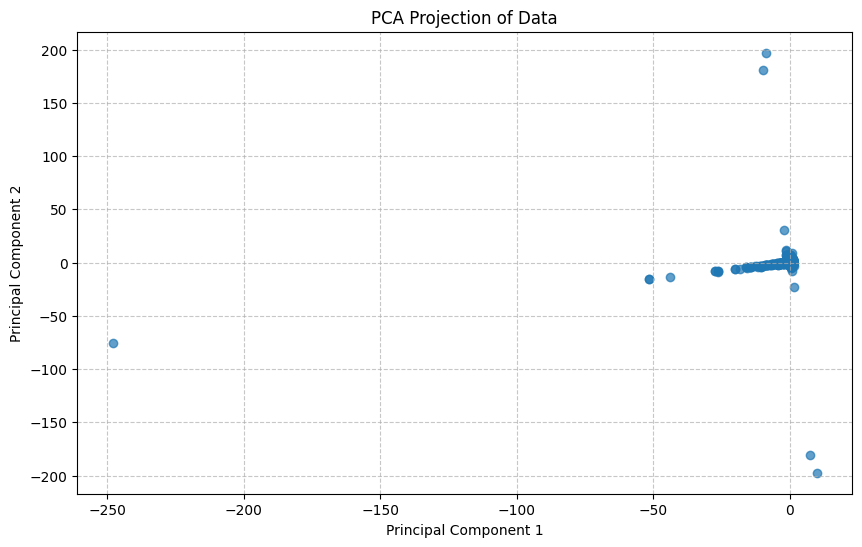

In [40]:
# Feature Engineering

# Standardisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)
df_scaled = pd.DataFrame(X_scaled, columns=df_filtered.columns)

print("\nData setelah standarisasi:")
print(df_scaled.describe())

# Reduksi dimensi dengan PCA untuk visualisasi dan analisis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

print("\nVariance explained oleh komponen PCA:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
plt.title('PCA Projection of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [17]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [18]:
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(df.select_dtypes(include=np.number))
selected_features = df.select_dtypes(include=np.number).columns[selector.get_support()]
df = df[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
    "DBSCAN": DBSCAN(eps=1, min_samples=5),
    "GMM": GaussianMixture(n_components=3, random_state=42),
    "Spectral": SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors')
}

In [24]:
import time
import warnings
from sklearn.utils import resample

results = {}
X_sampled = X_scaled  # Gunakan semua atau subset

# Jika terlalu berat, ambil 1000 sample
if len(X_scaled) > 1000:
    X_sampled = resample(X_scaled, n_samples=1000, random_state=42)

for name, model in models.items():
    print(f"\nRunning: {name}")
    start = time.time()

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            if name == "GMM":
                labels = model.fit_predict(X_sampled)
            else:
                model.fit(X_sampled)
                labels = model.labels_

            silhouette = silhouette_score(X_sampled, labels)
            ch_score = calinski_harabasz_score(X_sampled, labels)
            db_score = davies_bouldin_score(X_sampled, labels)

            results[name] = {
                "labels": labels,
                "silhouette": silhouette,
                "calinski_harabasz": ch_score,
                "davies_bouldin": db_score
            }

            print(f" {name} - Silhouette: {silhouette:.3f}, CH: {ch_score:.3f}, DB: {db_score:.3f}")

    except Exception as e:
        print(f" {name} gagal diproses: {str(e)}")

    end = time.time()
    print(f" Waktu proses: {end - start:.2f} detik")


Running: KMeans
 KMeans - Silhouette: 0.570, CH: 3289.359, DB: 0.534
 Waktu proses: 0.02 detik

Running: Agglomerative
 Agglomerative - Silhouette: 0.551, CH: 3056.923, DB: 0.549
 Waktu proses: 0.06 detik

Running: DBSCAN
 DBSCAN - Silhouette: 0.504, CH: 8.535, DB: 1.683
 Waktu proses: 0.04 detik

Running: GMM
 GMM - Silhouette: -0.048, CH: 10.047, DB: 6.489
 Waktu proses: 0.14 detik

Running: Spectral
 Spectral - Silhouette: 0.523, CH: 2655.856, DB: 0.525
 Waktu proses: 0.21 detik


 Menampilkan Silhouette plot untuk KMeans


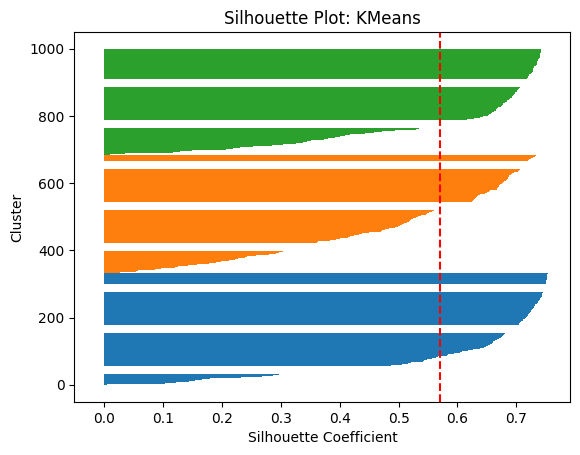

 Menampilkan Silhouette plot untuk Agglomerative


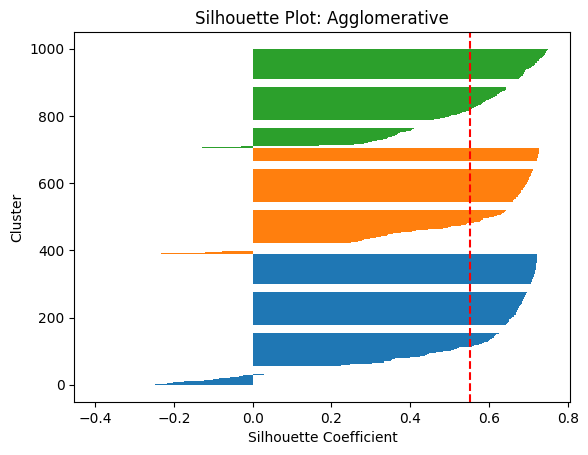

 Menampilkan Silhouette plot untuk DBSCAN


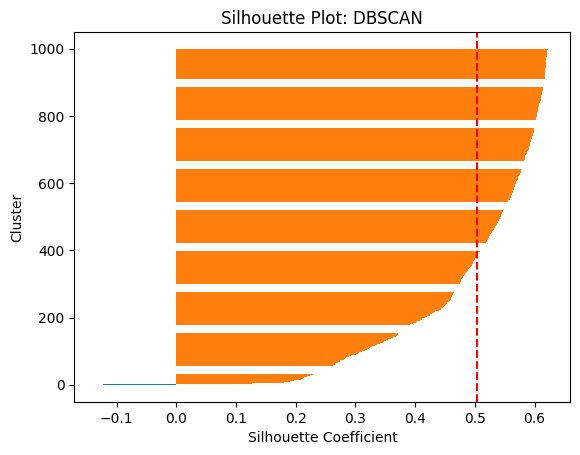

 Menampilkan Silhouette plot untuk GMM


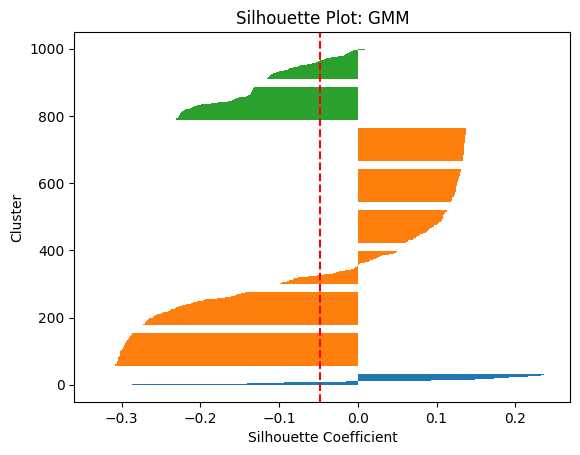

 Menampilkan Silhouette plot untuk Spectral


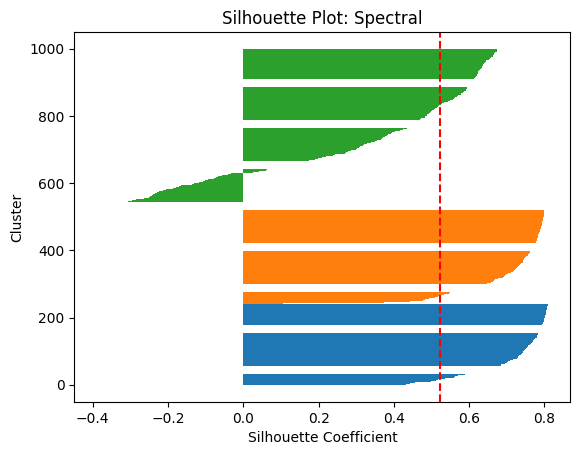

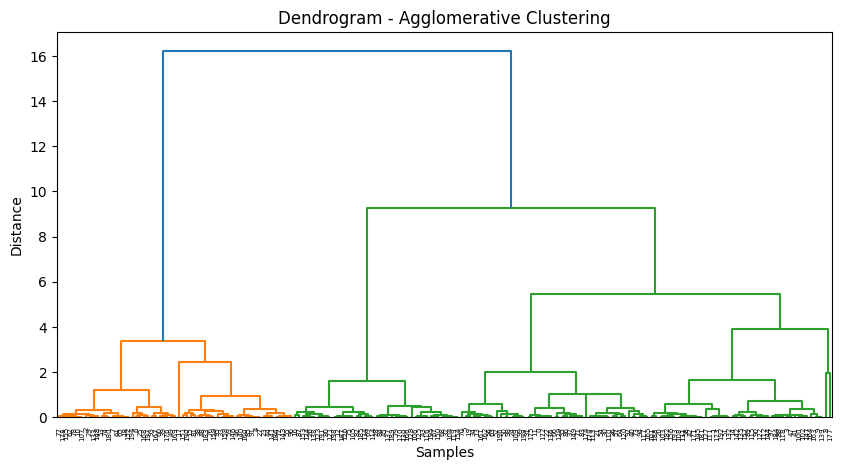

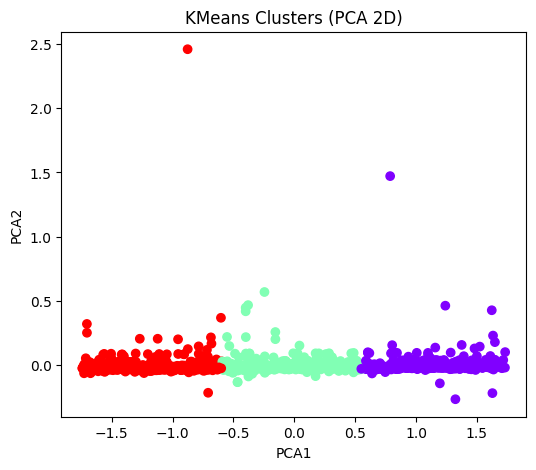

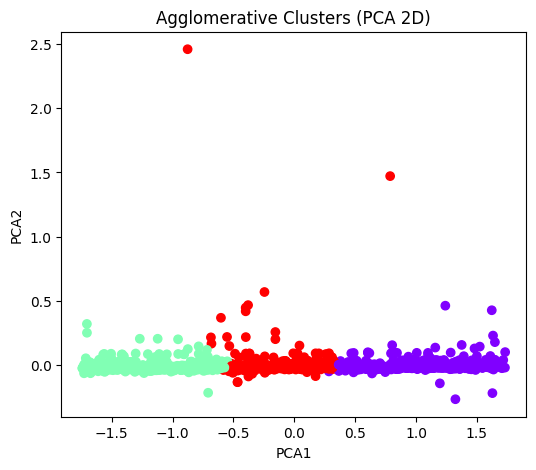

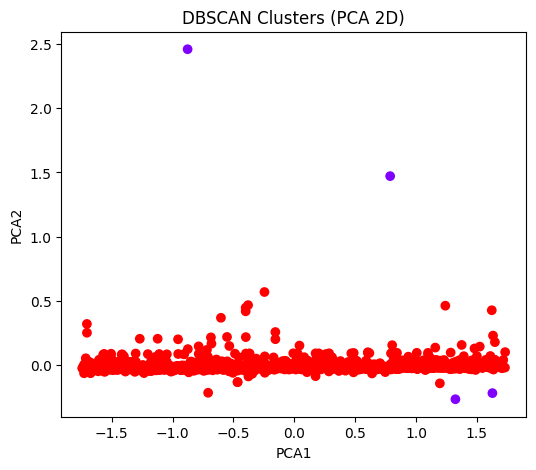

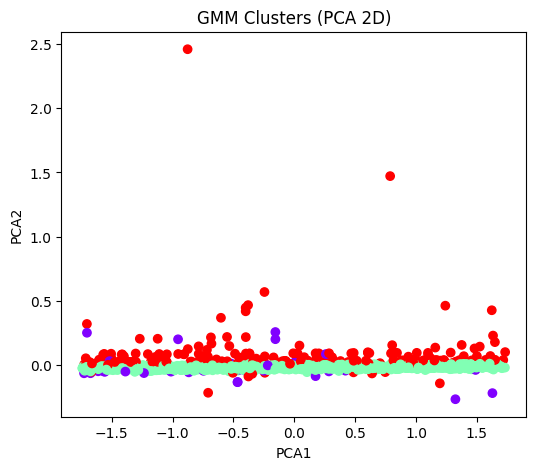

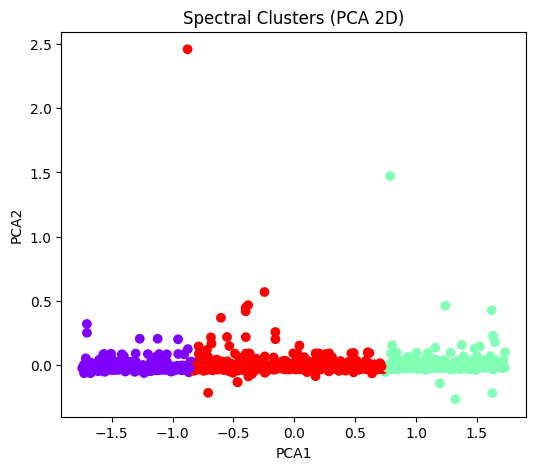

In [26]:
def plot_silhouette(X, labels, title):
    silhouette_vals = silhouette_samples(X, labels)
    y_ticks = []
    y_lower = 0
    for i in np.unique(labels):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + cluster_silhouette_vals.shape[0]
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals)
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower = y_upper
    plt.axvline(silhouette_vals.mean(), color="red", linestyle="--")
    plt.title(f"Silhouette Plot: {title}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

# Plot Silhouette untuk semua model
for name, result in results.items():
    print(f" Menampilkan Silhouette plot untuk {name}")
    plot_silhouette(X_sampled, result["labels"], name)

#  Dendrogram (maksimum 200 sampel saja agar cepat)
if len(X_sampled) > 200:
    dendro_sample = X_sampled[:200]
else:
    dendro_sample = X_sampled

plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(dendro_sample, method='ward'))
plt.title("Dendrogram - Agglomerative Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

#  Scatter Plot 2D pakai PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

for name, result in results.items():
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=result["labels"], cmap='rainbow')
    plt.title(f"{name} Clusters (PCA 2D)")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.show()


# **SOAL ANALISIS**

1. Jika algoritma K-Means menghasilkan nilai silhouette score rendah (0.3) meskipun elbow method menunjukkan K=5 sebagai optimal pada dataset ini, faktor apa yang menyebabkan inkonsistensi ini? Bagaimana strategi validasi alternatif (misal: analisis gap statistic atau validasi stabilitas cluster via bootstrapping) dapat mengatasi masalah ini, dan mengapa distribusi data non-spherical menjadi akar masalahnya?
  
  **Nilai silhouette score yang rendah meskipun elbow method menyarankan K=5 mengindikasikan bahwa cluster yang terbentuk tidak memiliki pemisahan yang jelas atau memiliki bentuk tidak bulat (non-spherical), yang memang sulit ditangani oleh K-Means. Distribusi data yang memanjang atau tidak seimbang bisa menyebabkan centroid berada di posisi sub-optimal. Validasi alternatif seperti gap statistic dapat membandingkan kualitas clustering dengan data acak, sementara bootstrapping dapat menilai kestabilan hasil cluster. Kedua metode ini lebih fleksibel terhadap bentuk cluster, sehingga lebih akurat dalam menilai kualitas klasterisasi dibanding metode berbasis inersia seperti elbow.**


2. Dalam dataset dengan campuran fitur numerik (Quantity, UnitPrice) dan kategorikal high-cardinality (Description), metode preprocessing apa yang efektif untuk menyelaraskan skala dan merepresentasikan fitur teks sebelum clustering? Jelaskan risiko menggunakan One-Hot Encoding untuk Description, dan mengapa teknik seperti TF-IDF atau embedding berdimensi rendah (UMAP) lebih robust untuk mempertahankan struktur cluster!
  
  **Untuk dataset campuran numerik dan fitur kategorikal seperti “Description” yang memiliki high-cardinality, preprocessing yang efektif melibatkan normalisasi fitur numerik (misalnya Min-Max scaling) serta representasi teks menggunakan TF-IDF atau embedding berdimensi rendah seperti UMAP. One-Hot Encoding pada Description akan menghasilkan ribuan kolom, meningkatkan kompleksitas dan sparsitas, sehingga menyulitkan algoritma clustering. Sebaliknya, TF-IDF atau UMAP menjaga hubungan semantik antar kata dan menurunkan dimensi, sehingga struktur cluster tetap terjaga dan performa model meningkat.**


3. Hasil clustering dengan DBSCAN sangat sensitif terhadap parameter epsilon—bagaimana menentukan nilai optimal epsilon secara adaptif untuk memisahkan cluster padat dari noise pada data transaksi yang tidak seimbang (misal: 90% pelanggan dari UK)? Jelaskan peran k-distance graph dan kuartil ke-3 dalam automasi parameter, serta mengapa MinPts harus disesuaikan berdasarkan kerapatan regional!
  
  **Dalam DBSCAN, pemilihan epsilon yang tepat sangat krusial, terutama pada data tidak seimbang seperti dominasi pelanggan UK. K-distance graph (misalnya dengan k = MinPts) digunakan untuk memvisualisasikan titik infleksi di mana jarak antar tetangga naik drastis; titik ini sering diambil sebagai epsilon optimal. Menggunakan kuartil ke-3 dari distribusi k-distance sebagai nilai epsilon adaptif dapat memisahkan noise dari cluster padat. Selain itu, MinPts sebaiknya disesuaikan berdasarkan kepadatan lokal agar DBSCAN tidak terlalu sensitif terhadap cluster kecil maupun terlalu longgar pada cluster besar.**


4. Jika analisis post-clustering mengungkapkan overlap signifikan antara cluster "high-value customers" dan "bulk buyers" berdasarkan total pengeluaran, bagaimana teknik semi-supervised (contoh: constrained clustering) atau integrasi metric learning (Mahalanobis distance) dapat memperbaiki pemisahan cluster? Jelaskan tantangan dalam mempertahankan interpretabilitas bisnis saat menggunakan pendekatan non-Euclidean!
  
  **Overlap antara cluster “high-value customers” dan “bulk buyers” menunjukkan bahwa fitur total pengeluaran saja belum cukup membedakan segmen. Pendekatan semi-supervised seperti constrained clustering dapat memanfaatkan domain knowledge berupa pairwise constraints (must-link/cannot-link) untuk mengarahkan pemisahan yang lebih bermakna. Integrasi metric learning seperti Mahalanobis distance memungkinkan model mengenali hubungan antar fitur yang lebih kompleks. Namun, tantangannya adalah menurunnya interpretabilitas bisnis karena hasil clustering lebih sulit diterjemahkan dalam logika segmen pelanggan yang sederhana.**


5. Bagaimana merancang temporal features dari InvoiceDate (misal: hari dalam seminggu, jam pembelian) untuk mengidentifikasi pola pembelian periodik (seperti transaksi pagi vs. malam)? Jelaskan risiko data leakage jika menggunakan agregasi temporal (misal: rata-rata pembelian bulanan) tanpa time-based cross-validation, dan mengapa lag features (pembelian 7 hari sebelumnya) dapat memperkenalkan noise pada cluster!

  **Untuk mengidentifikasi pola pembelian periodik, fitur temporal dari InvoiceDate seperti hari dalam minggu atau jam pembelian dapat membantu mengelompokkan perilaku harian pelanggan. Namun, agregasi temporal seperti rata-rata pembelian bulanan rentan terhadap data leakage jika dilakukan sebelum time-based cross-validation, karena informasi dari masa depan bisa bocor ke pelatihan. Selain itu, penggunaan lag features seperti jumlah pembelian 7 hari sebelumnya bisa memperkenalkan noise, terutama jika perilaku pembelian pelanggan tidak konsisten, sehingga perlu seleksi fitur yang hati-hati dan validasi berbasis waktu untuk menjaga keakuratan cluster.**
